In [1]:
%%capture
from tqdm import tqdm_notebook as tqdm

import pandas as pd

import time
t1 = time.time()

import os
import numpy as np

from pandas import ExcelWriter
from pandas import ExcelFile

from datetime import datetime

from matplotlib import cm
from pylab import rcParams
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d
import scipy.interpolate as spi
from scipy.interpolate import splrep, splev

import scipy.io
import math

from kmedoid import kMedoids
from sklearn import metrics

In [2]:
file_dir = os.path.join('/Users/digisha/Downloads/Fatigue_project/data')
file_name = os.path.join(file_dir, 'VAS_data_for_Digisha_073119.xlsx')
df = pd.read_excel(file_name, sheetname = "Sheet1")

#df = pd.read_excel(file_with_data, sheetname=sheet_with_data)

df.head()

/Users/digisha/anaconda3/lib/python3.7/site-packages/pandas/util/_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


,guid,subject_id,question_id,answer,other,is_checked,timestamp
0,473edf673e4c41e6bd329e01fcd0926b,1,1600,4,NaN,NaN,05-31-2018 08:45:51
1,11f45a3f6a5a456aa6d7e238fcf5801d,1,1601,0,NaN,NaN,05-31-2018 08:46:01
2,edb12413c16c457581358b8174855950,1,1602,0,NaN,NaN,05-31-2018 08:46:09
3,6fa93d8d070c4e3a89288038e5e99579,1,1603,0,NaN,NaN,05-31-2018 08:46:17
4,efec8a7b09a5499a85a4008bc606ef7f,1,1600,6,NaN,NaN,05-31-2018 16:16:58


In [3]:
#changing datatypes, time stamp in datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.drop(['guid', 'other', 'is_checked'], axis=1)

In [4]:
#only depression fatigue questionnare considererd
mask = (df['subject_id'] != 99998)
df = df.loc[mask].reset_index(drop=True)
#df['time'] = [t.time() for t in df['timestamp']]#.progress_apply(lambda x: x.timestamp)
#df['time'] = df['time'].apply(lambda x: x.strftime('%H:%M:%S'))
df.head()

,subject_id,question_id,answer,timestamp
0,1,1600,4,2018-05-31 08:45:51
1,1,1601,0,2018-05-31 08:46:01
2,1,1602,0,2018-05-31 08:46:09
3,1,1603,0,2018-05-31 08:46:17
4,1,1600,6,2018-05-31 16:16:58


In [5]:
datetime_object = datetime.strptime('00:00:00', '%H:%M:%S')
df['answer']=df.answer.astype('int64')
df['hour'] = 0.00

with tqdm(total=len(df)) as pbar:
    for i in range(len(df)):
        df['hour'][i] = (df['timestamp'][i] - datetime_object).seconds/(60*60)
        df['hour'][i] = df['hour'][i].round(2)
        pbar.update(1)
    
df.head()

/Users/digisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/digisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,subject_id,question_id,answer,timestamp,hour
0,1,1600,4,2018-05-31 08:45:51,8.76
1,1,1601,0,2018-05-31 08:46:01,8.77
2,1,1602,0,2018-05-31 08:46:09,8.77
3,1,1603,0,2018-05-31 08:46:17,8.77
4,1,1600,6,2018-05-31 16:16:58,16.28


In [6]:
# date column added to know if the questionnaire is a part of the same day or the next
df['date'] = [d.date() for d in df['timestamp']]

In [7]:
k = df.subject_id.unique()
print(np.sort(k))
len(k)

[ 1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20 22 23 24 25 26
 27 29 30 31 34 35 36 37 39 40 41 43 45 47 48 50 52 53]


42

In [8]:
dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
df['weekday'] = df['timestamp'].dt.dayofweek.map(dayOfWeek)
df.head()

,subject_id,question_id,answer,timestamp,hour,date,weekday
0,1,1600,4,2018-05-31 08:45:51,8.76,2018-05-31,Thursday
1,1,1601,0,2018-05-31 08:46:01,8.77,2018-05-31,Thursday
2,1,1602,0,2018-05-31 08:46:09,8.77,2018-05-31,Thursday
3,1,1603,0,2018-05-31 08:46:17,8.77,2018-05-31,Thursday
4,1,1600,6,2018-05-31 16:16:58,16.28,2018-05-31,Thursday


In [9]:
df['time'] = 0
k = 0
df['time'] = df['time'].astype('float')

patient = df.subject_id.unique()

# = [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 29, 30, 31, 34, 35, 36, 37, 39, 40, 41, 43, 45, 47, 48, 50, 52, 53]
qid = [1600,1601,1602,1603]

with tqdm(total= (len(patient)*len(qid)) ) as pbar:
    for q in qid:
        for pat in patient:
            #print('pat',pat)
            count = 0
            #print('count',count)
            for i in range(0,len(df)):

                if q == df['question_id'][i]:
                    if pat == df['subject_id'][i]:
                        #print('sub=pat', pat, i)
                        if (count == 0 and df['weekday'][i] == 'Monday'):
                            df['time'][i] = 0 + (df['hour'][i]/24)
                            #print('i',i)
                            count+= 1
                            k = i
                        elif (count == 0 and df['weekday'][i] != 'Monday'):
                            df['time'][i] = 99998
                        else:
                            df['time'][i] = (df['timestamp'][i] - df['timestamp'][k]).days + (df['hour'][i]/24)
                            #count+= 1
            pbar.update(1)
        
mask = (df['time'] != 99998)
df = df.loc[mask].reset_index(drop=True)

df['time'] = df['time'].round(3)
df = df.sort_values(['subject_id', 'time'], ascending=[True, True])
df.head(7)

/Users/digisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/digisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/digisha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,subject_id,question_id,answer,timestamp,hour,date,weekday,time
0,1,1600,8,2018-06-04 00:06:49,0.11,2018-06-04,Monday,0.005
1,1,1601,3,2018-06-04 00:06:58,0.12,2018-06-04,Monday,0.005
2,1,1602,4,2018-06-04 00:07:12,0.12,2018-06-04,Monday,0.005
3,1,1603,1,2018-06-04 00:07:17,0.12,2018-06-04,Monday,0.005
4,1,1600,1,2018-06-04 09:19:33,9.33,2018-06-04,Monday,0.389
5,1,1601,1,2018-06-04 09:19:40,9.33,2018-06-04,Monday,0.389
6,1,1602,1,2018-06-04 09:19:50,9.33,2018-06-04,Monday,0.389


In [10]:
df.head()

,subject_id,question_id,answer,timestamp,hour,date,weekday,time
0,1,1600,8,2018-06-04 00:06:49,0.11,2018-06-04,Monday,0.005
1,1,1601,3,2018-06-04 00:06:58,0.12,2018-06-04,Monday,0.005
2,1,1602,4,2018-06-04 00:07:12,0.12,2018-06-04,Monday,0.005
3,1,1603,1,2018-06-04 00:07:17,0.12,2018-06-04,Monday,0.005
4,1,1600,1,2018-06-04 09:19:33,9.33,2018-06-04,Monday,0.389


In [11]:
mask = (df['question_id'] == 1600)
df_00 = df.loc[mask].reset_index(drop=True)

mask = (df['question_id'] == 1601)
df_01 = df.loc[mask].reset_index(drop=True)

mask = (df['question_id'] == 1602)
df_02 = df.loc[mask].reset_index(drop=True)

mask = (df['question_id'] == 1603)
df_03 = df.loc[mask].reset_index(drop=True)

In [12]:
df_00 = df_00.drop(['timestamp', 'hour', 'date', "weekday", "question_id"], axis=1)
df_01 = df_01.drop(['timestamp', 'hour', 'date', "weekday", "question_id"], axis=1)
df_02 = df_02.drop(['timestamp', 'hour', 'date', "weekday", "question_id"], axis=1)
df_03 = df_03.drop(['timestamp', 'hour', 'date', "weekday", "question_id"], axis=1)

In [13]:
df_00.head()

,subject_id,answer,time
0,1,8,0.005
1,1,1,0.389
2,1,7,0.792
3,1,7,0.960
4,1,7,1.038


In [14]:
# Utility Functions

color_lst = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_lst.extend(['firebrick', 'olive', 'indigo', 'khaki', 'teal', 'saddlebrown', 
                 'skyblue', 'coral', 'darkorange', 'lime', 'darkorchid', 'dimgray'])

def plot_cluster(traj_lst, cluster_lst):
    '''
    Plots given trajectories with a color that is specific for every trajectory's own cluster index.
    Outlier trajectories which are specified with -1 in `cluster_lst` are plotted dashed with black color
    '''
    cluster_count = np.max(cluster_lst) + 1
    
    for traj, cluster in zip(traj_lst, cluster_lst):
        
        if cluster == -1:
            #pass
            # Means it it a noisy trajectory, paint it black
            plt.plot(traj[:, 0], traj[:, 1], c='k', linestyle='dashed')
        
        else:
            plt.plot(traj[:, 0], traj[:, 1], c=color_lst[cluster % len(color_lst)])
    plt.show()

# Some visualization stuff, not so important
sns.set()
plt.rcParams['figure.figsize'] = (24, 12)

Total number of clusters : 20
40
Silhoutte Coefficient : 0.022


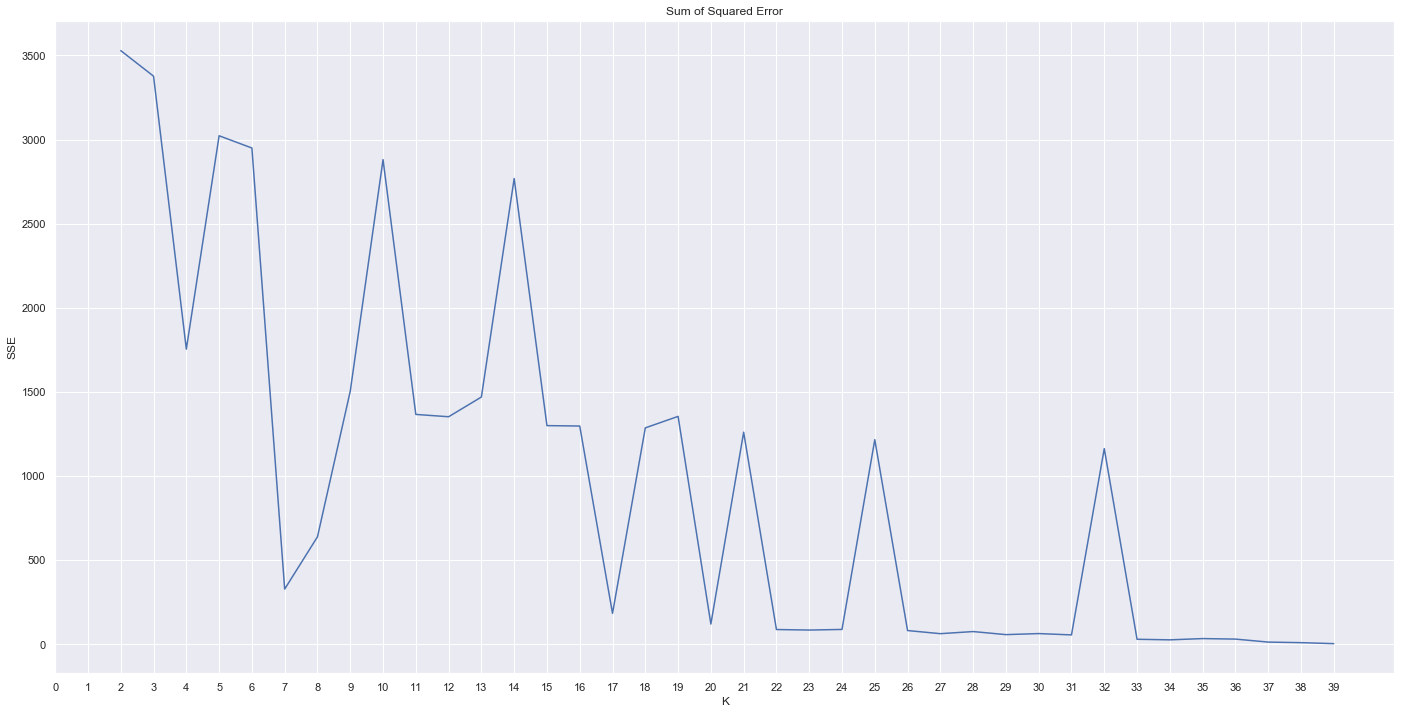

In [15]:
UniqueNames = df_00.subject_id.unique()

#create a data frame dictionary to store your data frames
DataFrameDict = {elem : pd.DataFrame for elem in UniqueNames}
Dict = {elem : pd.DataFrame for elem in UniqueNames}

for key in DataFrameDict.keys():
    DataFrameDict[key] = df_00[:][df_00.subject_id == key]

#Dict = {}
traj_lst = []
traj_lst1 = []

for key in UniqueNames:
    #print(DataFrameDict[key])
    x = DataFrameDict[key]['time'].values
    y = DataFrameDict[key]['answer'].values
    np.set_printoptions(formatter={'float_kind':'{:0.3f}'.format})
    #xnew = np.arange(0,14,1/48)
    #intfunc = spi.interp1d(x,y,kind = 'linear', fill_value=(y.min(), y.max()), bounds_error=False)
    #ynew = intfunc(xnew)
    #xnew = xnew.round(3)
    #ynew = ynew.round(3)
    #X1 = np.array(list(zip(xnew, ynew)))
    X = np.array(list(zip(x, y)))
    traj_lst.append(X)
    #traj_lst1.append(X1)
    #dataset = pd.DataFrame({'time': X[:, 0], 'answer': X[:, 1]})
    #Dict[key] = dataset[:]
    #Dict[key].append(X)
    #print(Dict[key])

#for traj in traj_lst:
#    plt.plot(traj[:, 0], traj[:, 1])
    

# 2 - Trajectory segmentation
degree_threshold = 5

for traj_index, traj in enumerate(traj_lst):
    
    hold_index_lst = []
    previous_azimuth= 1000
    
    for point_index, point in enumerate(traj[:-1]):
        next_point = traj[point_index + 1]
        diff_vector = next_point - point
        azimuth = (math.degrees(math.atan2(*diff_vector)) + 360) % 360
        
        if abs(azimuth - previous_azimuth) > degree_threshold:
            hold_index_lst.append(point_index)
            previous_azimuth = azimuth
    hold_index_lst.append(traj.shape[0] - 1) # Last point of trajectory is always added
    
    traj_lst[traj_index] = traj[hold_index_lst, :]

from scipy.spatial.distance import directed_hausdorff

def hausdorff( u, v):
    d = max(directed_hausdorff(u, v)[0], directed_hausdorff(v, u)[0])
    return d

traj_count = len(traj_lst)
D = np.zeros((traj_count, traj_count))

# This may take a while
for i in range(traj_count):
    for j in range(i + 1, traj_count):
        distance = hausdorff(traj_lst[i], traj_lst[j])
        D[i, j] = distance
        D[j, i] = distance
        
        
K = 20
M, C = kMedoids(D, K)

#  Postprocessing

print("Total number of clusters : %s" % K)

labels = np.zeros((len(traj_lst),))

lol = 0
for i in range(K):
    for index in C[i]:
        lol += 1
        labels[index] = i

print(lol)

clusters = [[] for i in range(K)]
no = len(traj_lst)
for i in range(no):
    label = int(labels[i])
    clusters[label].append(traj_lst[i])

silhoutte_score = metrics.silhouette_score(D, labels, sample_size=len(traj_lst))
print("Silhoutte Coefficient : %.3f" % silhoutte_score)

sse_list = []
for h in range(2, 40):
    M, C = kMedoids(D, h)
    sse = 0
    for i in range(h):
        medoid_index = M[i]
        sse += np.sum(D[medoid_index,C[i]] ** 2)
    sse_list.append(sse)
    #print(sse)

plt.plot(range(2, 40), sse_list)
plt.xticks(np.arange(0, 40, 1))
plt.xlabel("K")
plt.ylabel("SSE")
plt.title("Sum of Squared Error")
plt.show()

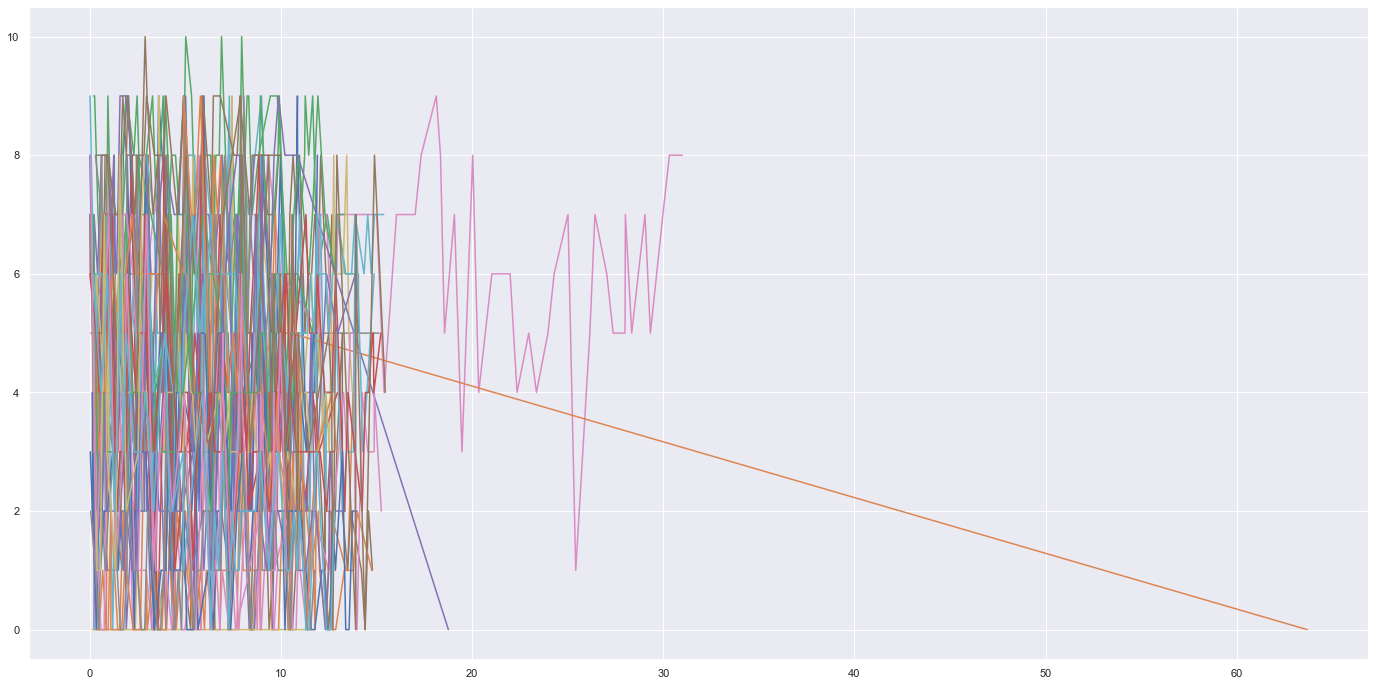

In [28]:
UniqueNames = df_00.subject_id.unique()

#create a data frame dictionary to store your data frames
DataFrameDict = {elem : pd.DataFrame for elem in UniqueNames}
Dict = {elem : pd.DataFrame for elem in UniqueNames}

for key in DataFrameDict.keys():
    DataFrameDict[key] = df_00[:][df_00.subject_id == key]

#Dict = {}
traj_lst = []
traj_lst1 = []

for key in UniqueNames:
    #print(DataFrameDict[key])
    x = DataFrameDict[key]['time'].values
    y = DataFrameDict[key]['answer'].values
    np.set_printoptions(formatter={'float_kind':'{:0.3f}'.format})
    #xnew = np.arange(0,14,1/48)
    #intfunc = spi.interp1d(x,y,kind = 'linear', fill_value=(y.min(), y.max()), bounds_error=False)
    #ynew = intfunc(xnew)
    #xnew = xnew.round(3)
    #ynew = ynew.round(3)
    #X1 = np.array(list(zip(xnew, ynew)))
    X = np.array(list(zip(x, y)))
    traj_lst1.append(X)
    #traj_lst1.append(X1)
    #dataset = pd.DataFrame({'time': X[:, 0], 'answer': X[:, 1]})
    #Dict[key] = dataset[:]
    #Dict[key].append(X)
    #print(Dict[key])

for traj in traj_lst1:
    plt.plot(traj[:, 0], traj[:, 1])
    

# 2 - Trajectory segmentation
degree_threshold = 5

for traj_index, traj in enumerate(traj_lst1):
    
    hold_index_lst = []
    previous_azimuth= 1000
    
    for point_index, point in enumerate(traj[:-1]):
        next_point = traj[point_index + 1]
        diff_vector = next_point - point
        azimuth = (math.degrees(math.atan2(*diff_vector)) + 360) % 360
        
        if abs(azimuth - previous_azimuth) > degree_threshold:
            hold_index_lst.append(point_index)
            previous_azimuth = azimuth
    hold_index_lst.append(traj.shape[0] - 1) # Last point of trajectory is always added
    
    traj_lst1[traj_index] = traj[hold_index_lst, :]

from scipy.spatial.distance import directed_hausdorff

def hausdorff( u, v):
    d = max(directed_hausdorff(u, v)[0], directed_hausdorff(v, u)[0])
    return d

traj_count = len(traj_lst1)
D = np.zeros((traj_count, traj_count))

# This may take a while
for i in range(traj_count):
    for j in range(i + 1, traj_count):
        distance = hausdorff(traj_lst1[i], traj_lst1[j])
        D[i, j] = distance
        D[j, i] = distance

# 4 clustering- kmedoids

k = 26 # The number of clusters
medoid_center_lst, cluster2index_lst = kMedoids(D, k)

cluster_lst00 = np.empty((traj_count,), dtype=int)

for cluster in cluster2index_lst:
    cluster_lst00[cluster2index_lst[cluster]] = cluster

UniqueNames = df_01.subject_id.unique()

#create a data frame dictionary to store your data frames
DataFrameDict = {elem : pd.DataFrame for elem in UniqueNames}
Dict = {elem : pd.DataFrame for elem in UniqueNames}

for key in DataFrameDict.keys():
    DataFrameDict[key] = df_01[:][df_01.subject_id == key]


traj_lst2 = []

for key in UniqueNames:
    x = DataFrameDict[key]['time'].values
    y = DataFrameDict[key]['answer'].values
    np.set_printoptions(formatter={'float_kind':'{:0.3f}'.format})
    X = np.array(list(zip(x, y)))
    traj_lst2.append(X)

#for traj in traj_lst:
#   plt.plot(traj[:, 0], traj[:, 1])
    

# 2 - Trajectory segmentation
degree_threshold = 5

for traj_index, traj in enumerate(traj_lst2):
    
    hold_index_lst = []
    previous_azimuth= 1000
    
    for point_index, point in enumerate(traj[:-1]):
        next_point = traj[point_index + 1]
        diff_vector = next_point - point
        azimuth = (math.degrees(math.atan2(*diff_vector)) + 360) % 360
        
        if abs(azimuth - previous_azimuth) > degree_threshold:
            hold_index_lst.append(point_index)
            previous_azimuth = azimuth
    hold_index_lst.append(traj.shape[0] - 1) # Last point of trajectory is always added
    
    traj_lst2[traj_index] = traj[hold_index_lst, :]

def hausdorff( u, v):
    d = max(directed_hausdorff(u, v)[0], directed_hausdorff(v, u)[0])
    return d

traj_count = len(traj_lst2)
D = np.zeros((traj_count, traj_count))

# This may take a while
for i in range(traj_count):
    for j in range(i + 1, traj_count):
        distance = hausdorff(traj_lst2[i], traj_lst2[j])
        D[i, j] = distance
        D[j, i] = distance

# 4 clustering- kmedoids

k = 26 # The number of clusters
medoid_center_lst, cluster2index_lst = kMedoids(D, k)

cluster_lst01 = np.empty((traj_count,), dtype=int)

for cluster in cluster2index_lst:
    cluster_lst01[cluster2index_lst[cluster]] = cluster

UniqueNames = df_02.subject_id.unique()

#create a data frame dictionary to store your data frames
DataFrameDict = {elem : pd.DataFrame for elem in UniqueNames}
Dict = {elem : pd.DataFrame for elem in UniqueNames}

for key in DataFrameDict.keys():
    DataFrameDict[key] = df_02[:][df_02.subject_id == key]

#Dict = {}
traj_lst = []
traj_lst3 = []

for key in UniqueNames:
    #print(DataFrameDict[key])
    x = DataFrameDict[key]['time'].values
    y = DataFrameDict[key]['answer'].values
    np.set_printoptions(formatter={'float_kind':'{:0.3f}'.format})
    X = np.array(list(zip(x, y)))
    traj_lst3.append(X)

#for traj in traj_lst:
#    plt.plot(traj[:, 0], traj[:, 1])
    

# 2 - Trajectory segmentation
degree_threshold = 5

for traj_index, traj in enumerate(traj_lst):
    
    hold_index_lst = []
    previous_azimuth= 1000
    
    for point_index, point in enumerate(traj[:-1]):
        next_point = traj[point_index + 1]
        diff_vector = next_point - point
        azimuth = (math.degrees(math.atan2(*diff_vector)) + 360) % 360
        
        if abs(azimuth - previous_azimuth) > degree_threshold:
            hold_index_lst.append(point_index)
            previous_azimuth = azimuth
    hold_index_lst.append(traj.shape[0] - 1) # Last point of trajectory is always added
    
    traj_lst3[traj_index] = traj[hold_index_lst, :]

from scipy.spatial.distance import directed_hausdorff

def hausdorff( u, v):
    d = max(directed_hausdorff(u, v)[0], directed_hausdorff(v, u)[0])
    return d

traj_count = len(traj_lst3)
D = np.zeros((traj_count, traj_count))

# This may take a while
for i in range(traj_count):
    for j in range(i + 1, traj_count):
        distance = hausdorff(traj_lst3[i], traj_lst3[j])
        D[i, j] = distance
        D[j, i] = distance

# 4 clustering- kmedoids

k = 26 # The number of clusters
medoid_center_lst, cluster2index_lst = kMedoids(D, k)

cluster_lst02 = np.empty((traj_count,), dtype=int)

for cluster in cluster2index_lst:
    cluster_lst02[cluster2index_lst[cluster]] = cluster


UniqueNames = df_03.subject_id.unique()

#create a data frame dictionary to store your data frames
DataFrameDict = {elem : pd.DataFrame for elem in UniqueNames}
Dict = {elem : pd.DataFrame for elem in UniqueNames}

for key in DataFrameDict.keys():
    DataFrameDict[key] = df_03[:][df_03.subject_id == key]


traj_lst4 = []

for key in UniqueNames:
    #print(DataFrameDict[key])
    x = DataFrameDict[key]['time'].values
    y = DataFrameDict[key]['answer'].values
    np.set_printoptions(formatter={'float_kind':'{:0.3f}'.format})
    X = np.array(list(zip(x, y)))
    traj_lst4.append(X)

#for traj in traj_lst:
#    plt.plot(traj[:, 0], traj[:, 1])
    

# 2 - Trajectory segmentation
degree_threshold = 5

for traj_index, traj in enumerate(traj_lst):
    
    hold_index_lst = []
    previous_azimuth= 1000
    
    for point_index, point in enumerate(traj[:-1]):
        next_point = traj[point_index + 1]
        diff_vector = next_point - point
        azimuth = (math.degrees(math.atan2(*diff_vector)) + 360) % 360
        
        if abs(azimuth - previous_azimuth) > degree_threshold:
            hold_index_lst.append(point_index)
            previous_azimuth = azimuth
    hold_index_lst.append(traj.shape[0] - 1) # Last point of trajectory is always added
    
    traj_lst4[traj_index] = traj[hold_index_lst, :]



from scipy.spatial.distance import directed_hausdorff

def hausdorff( u, v):
    d = max(directed_hausdorff(u, v)[0], directed_hausdorff(v, u)[0])
    return d

traj_count = len(traj_lst4)
D = np.zeros((traj_count, traj_count))

# This may take a while
for i in range(traj_count):
    for j in range(i + 1, traj_count):
        distance = hausdorff(traj_lst4[i], traj_lst4[j])
        D[i, j] = distance
        D[j, i] = distance

# 4 clustering- kmedoids

k = 26 # The number of clusters
medoid_center_lst, cluster2index_lst = kMedoids(D, k)

cluster_lst03 = np.empty((traj_count,), dtype=int)

for cluster in cluster2index_lst:
    cluster_lst03[cluster2index_lst[cluster]] = cluster

In [35]:
%matplotlib qt
plt.figure(figsize = (24,12))

plt.subplot(2, 2, 1)
plt.title('Fatigue - 1600')
plt.xlim(0, 20)
plot_cluster(traj_lst1, cluster_lst00)

#---------------
plt.subplot(2, 2, 2)
plt.title('Depression - 1601')
plt.xlim(0, 20)
plot_cluster(traj_lst2, cluster_lst01)

#---------------
plt.subplot(2, 2, 3)
plt.title('Anxiety - 1602')
plt.xlim(0, 20)
plot_cluster(traj_lst3, cluster_lst02)

#---------------
plt.subplot(2, 2, 4)
plt.xlim(0, 20)
plt.title('Pain - 1603') 
plot_cluster(traj_lst4, cluster_lst03)

In [30]:
"""# 3 - Distance matrix
from scipy.spatial.distance import directed_hausdorff

def hausdorff(a, b):
    d = np.cov(traj_lst1[a], traj_lst1[b], bias=True)[0][1]
    return d

traj_count = len(traj_lst1)
D = np.zeros((traj_count, traj_count))

# This may take a while
for i in range(traj_count):
    for j in range(i + 1, traj_count):
        #print(i,j)
        #print(hausdorff(i, j))
        distance = hausdorff(i, j)
        D[i, j] = distance
        D[j, i] = distance
        
D"""

'# 3 - Distance matrix\nfrom scipy.spatial.distance import directed_hausdorff\n\ndef hausdorff(a, b):\n    d = np.cov(traj_lst1[a], traj_lst1[b], bias=True)[0][1]\n    return d\n\ntraj_count = len(traj_lst1)\nD = np.zeros((traj_count, traj_count))\n\n# This may take a while\nfor i in range(traj_count):\n    for j in range(i + 1, traj_count):\n        #print(i,j)\n        #print(hausdorff(i, j))\n        distance = hausdorff(i, j)\n        D[i, j] = distance\n        D[j, i] = distance\n        \nD'

In [31]:
print(cluster_lst00,cluster_lst01,cluster_lst02,cluster_lst03)

[ 0  1  2  3  4 20 10  5  6  7  8  9  8 16 19 11 12 13 14 15 16 17 18  6
 15 21  3  7  3  5 23 20 18 22 23 24 16 23 21 25] [ 0  1  2 15  3  4  5  6 19  7  0  8  4  9 10 11 12 13 14 23 15 24 22  4
 16 17  7 18 22  6 20 23 21 22 23 11  3 15 18 25] [ 0  1  2  3 21  4 10  5  4  6  7 10  8  9 18  2 11 21 12 13 14 15 16 17
 23 19  6  6 16 20  8  9 22 23  8 13 24 14 22 25] [ 0  1  2 22  3  4  9 18  5 23  8  6  7 14 20 10  4  4 11  4  4 12 22 13
 14  0 15 16 17  4 19  4 21 22 14 13 15 24 25 24]


In [32]:
X = np.array(list(zip(UniqueNames, cluster_lst00,cluster_lst01,cluster_lst02,cluster_lst03)))

In [33]:
X

array([[ 1,  0,  0,  0,  0],
       [ 2,  1,  1,  1,  1],
       [ 3,  2,  2,  2,  2],
       [ 4,  3, 15,  3, 22],
       [ 5,  4,  3, 21,  3],
       [ 6, 20,  4,  4,  4],
       [ 7, 10,  5, 10,  9],
       [ 8,  5,  6,  5, 18],
       [ 9,  6, 19,  4,  5],
       [11,  7,  7,  6, 23],
       [12,  8,  0,  7,  8],
       [13,  9,  8, 10,  6],
       [14,  8,  4,  8,  7],
       [15, 16,  9,  9, 14],
       [16, 19, 10, 18, 20],
       [17, 11, 11,  2, 10],
       [18, 12, 12, 11,  4],
       [20, 13, 13, 21,  4],
       [22, 14, 14, 12, 11],
       [23, 15, 23, 13,  4],
       [24, 16, 15, 14,  4],
       [25, 17, 24, 15, 12],
       [26, 18, 22, 16, 22],
       [27,  6,  4, 17, 13],
       [29, 15, 16, 23, 14],
       [30, 21, 17, 19,  0],
       [31,  3,  7,  6, 15],
       [34,  7, 18,  6, 16],
       [35,  3, 22, 16, 17],
       [36,  5,  6, 20,  4],
       [37, 23, 20,  8, 19],
       [39, 20, 23,  9,  4],
       [40, 18, 21, 22, 21],
       [41, 22, 22, 23, 22],
       [45, 23

In [34]:
(time.time() - t1)/60

81.08402332862218

In [38]:
plt.title('Fatigue - 1600')
plt.xlim(0, 20)
plot_cluster(traj_lst1, cluster_lst00)